In [1]:
import tracemalloc
import time
import scanpy as sc
import pandas as pd

import cupy as cp
import cupyx
import numpy as np
from tqdm import tqdm

from icecream import ic

from SEACells.core import SEACells


findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
from scipy.sparse import csr_matrix

In [3]:
ad = sc.read("/home/aparna/DATA/aparnakumar/50000_cells/mouse_marioni_50k.h5ad") 
num_cells = 10000
ad = ad[:num_cells]  

In [4]:
## Core parameters 
# number of SEACells
n_SEACells = num_cells // 75
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                            # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

In [5]:
model2 = SEACells(ad, 
                 use_gpu=False, 
                 use_sparse=True, 
                 build_kernel_on=build_kernel_on, 
                 n_SEACells=n_SEACells, 
                 n_waypoint_eigs=n_waypoint_eigs,
                 convergence_epsilon = 1e-5)

model2.construct_kernel_matrix()
model2.initialize_archetypes()
model2.initialize()

SPARSE AND NOT GPU
TRYING SEACellsCPU
Welcome to SEACells!
Computing kNN graph using scanpy NN ...


Computing radius for adaptive bandwidth kernel...



Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...



Building similarity LIL matrix...



Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...


  0%|          | 0/27 [00:00<?, ?it/s]

Done.
Sampling waypoints ...
Done.
Selecting 116 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 27/27 [00:00<00:00, 59.76it/s]


Selecting 17 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.00178


In [6]:
model4 = SEACells(ad, 
                 use_gpu=True, 
                 use_sparse=True, 
                 build_kernel_on=build_kernel_on, 
                 n_SEACells=n_SEACells, 
                 n_waypoint_eigs=n_waypoint_eigs,
                 convergence_epsilon = 1e-5)

model4.construct_kernel_matrix()
model4.initialize_archetypes()
model4.initialize()

SPARSE AND GPU
TRYING SEACellsGPU
Welcome to SEACells GPU!
build_graph.SEACellGraph completed
Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...



Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...



Building similarity LIL matrix...



Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...


  0%|          | 0/27 [00:00<?, ?it/s]

Done.
Sampling waypoints ...
Done.
Selecting 116 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


/home/aparna/miniconda/envs/env_SEACells/lib/python3.8/site-packages/cupyx/scipy/sparse/_compressed.py:545: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive.
  warnings.warn('Changing the sparsity structure of a '
100%|██████████| 27/27 [00:01<00:00, 25.61it/s]


Selecting 17 cells from greedy initialization.
Randomly initialized A matrix.
Convergence threshold set to 0.0017756354130196014 based on epsilon = 1e-05


In [7]:
model3 = SEACells(ad, 
                 use_gpu=True, 
                 use_sparse=False, 
                 build_kernel_on=build_kernel_on, 
                 n_SEACells=n_SEACells, 
                 n_waypoint_eigs=n_waypoint_eigs,
                 convergence_epsilon = 1e-5)

model3.construct_kernel_matrix()
model3.initialize_archetypes()
model3.initialize()

NOT SPARSE AND GPU
TRYING SEACellsGPUDense
Welcome to SEACells GPU!
Computing kNN graph using scanpy NN ...


Computing radius for adaptive bandwidth kernel...



Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...



Building similarity LIL matrix...



Constructing CSR matrix...
Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...


  0%|          | 0/24 [00:00<?, ?it/s]

Done.
Sampling waypoints ...
Done.
Selecting 119 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 24/24 [00:00<00:00, 57.54it/s]


Selecting 14 cells from greedy initialization.
Randomly initialized A matrix.
Setting convergence threshold at 0.00178


In [8]:
A0s = {'cpu': model2.A0, 'gpu_sparse': model4.A0, 'gpu_dense': model3.A0}
B0s = {'cpu': model2.B0, 'gpu_sparse': model4.B0, 'gpu_dense': model3.B0}

In [9]:
from sklearn.preprocessing import normalize

k = 13 
n = 1000 
archetypes_per_cell = int(k * 0.25)
rows = np.random.randint(0, k, size=(n, archetypes_per_cell)).reshape(-1)
columns = np.repeat(np.arange(n), archetypes_per_cell)

A0 = csr_matrix(
    (np.random.random(len(rows)), (rows, columns)), shape=(k, n)
)

ic(type(A0))

ic(type(normalize(A0, axis=0, norm="l1")))

normed = normalize(A0, axis=0, norm="l1")

ic| type(A0): <class 'scipy.sparse.csr.csr_matrix'>
ic| type(normalize(A0, axis=0, norm="l1")): <class 'scipy.sparse.csc.csc_matrix'>


In [10]:
v1 = cupyx.scipy.sparse.csr_matrix(normed) 
v2 = cupyx.scipy.sparse.csc_matrix(normed)

diff = v1 - v2 

# Print frequency table of differences 
ic(pd.Series(diff.get().toarray().flatten()).value_counts())

ic| pd.Series(diff.get().toarray().flatten()).value_counts(): 0.0    13000
                                                              dtype: int64


0.0    13000
dtype: int64

In [11]:
# Check the types of the A0s 
for key, val in A0s.items():
    print(key, type(val))

cpu <class 'scipy.sparse.csc.csc_matrix'>
gpu_sparse <class 'cupyx.scipy.sparse._csr.csr_matrix'>
gpu_dense <class 'numpy.ndarray'>


In [12]:
import matplotlib.pyplot as plt 
import seaborn as sns

def compute_sparsity(M):
    """
    Compute the proportion of non-zero elements in a matrix
    @param M: a dense numpy array
    """
    try: 
        sparsity = M.nnz / (M.shape[0] * M.shape[1])
    except Exception: 
        sparsity = np.count_nonzero(M) / M.size

    return sparsity

def check_results(d):
    """
    Check that all results in a dictionary are the same
    """
    
    v2 = d['cpu']
    print('Sparsity of {} is {}'.format('CPU', compute_sparsity(v2)))
    # Turn v2 into a numpy array
    v2 = v2.toarray()
    elt2 = np.where(v2.flatten() != 0)[0]

    for key in ['gpu_sparse', 'gpu_dense']:
        v1 = d[key]
        print('Sparsity of {} is {}'.format(key, compute_sparsity(v1)))
        # Convert to dense for comparison
        if key == 'gpu_sparse':
            v1 = cp.array(v1.todense())
        # Turn into a numpy array
        v1 = cp.asnumpy(v1)
        # Grab the nonzero elements of v1
        elt1 = np.where(v1.flatten() != 0)[0]
        # Check that the nonzero elements are the same
        try:
            assert set(list(elt1)) == set(list(elt2))
        except AssertionError:
            print('Nonzero elements of {} are different from nonzero elements of {}'.format('CPU', key))

In [13]:
check_results(A0s)

Sparsity of CPU is 0.2203142857142857
Sparsity of gpu_sparse is 0.22063308270676693
Nonzero elements of CPU are different from nonzero elements of gpu_sparse
Sparsity of gpu_dense is 1.0


Nonzero elements of CPU are different from nonzero elements of gpu_dense


In [14]:
from sklearn.preprocessing import normalize
from cupyx.scipy.sparse.linalg import norm

A0_cpu = A0s['cpu'] 
normed_cpu = normalize(A0_cpu, axis=0, norm="l1")

A0_gpu_sparse = cupyx.scipy.sparse.csr_matrix(A0_cpu) 
# Check dtype of A0_gpu_sparse 
print(A0_gpu_sparse.dtype)

l1_norms  = norm(A0_gpu_sparse, ord=1, axis=0)
l1_norms[l1_norms == 0] = 1.0
normed_gpu_sparse = A0_gpu_sparse.multiply(1.0 / l1_norms)

# Check dtype of normed_gpu_sparse
print(normed_gpu_sparse.dtype)

# compare normed_cpu and normed_gpu_sparse
print(normed_cpu.shape)
print(normed_gpu_sparse.shape)

# print type of normed_cpu and normed_gpu_sparse 
print(type(normed_cpu))
print(type(normed_gpu_sparse))

diff = normed_cpu - normed_gpu_sparse.get()
# Make a frequency table of the differences 
pd.Series(diff.toarray().flatten()).value_counts()

float64
float64
(133, 10000)
(133, 10000)
<class 'scipy.sparse.csc.csc_matrix'>
<class 'cupyx.scipy.sparse._csr.csr_matrix'>


 0.000000e+00    1162740
-6.938894e-18      33147
 6.938894e-18      28338
-1.387779e-17      20700
-3.469447e-18      16393
                  ...   
-1.110223e-16          1
 6.938894e-17          1
-1.355253e-19          1
 1.084202e-18          1
-2.032879e-20          1
Length: 80, dtype: int64

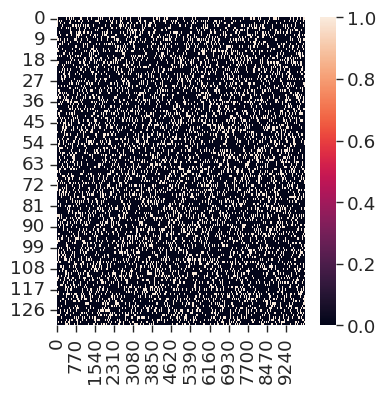

In [15]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100

def plot_matrix(matrix_np, title=None):
    """
    Plot a matrix
    @param M: a dense numpy array
    """
    # Create a binary version of the matrix
    binary_matrix = matrix_np.copy()
    binary_matrix[binary_matrix != 0] = 1

    # Plot the dataframe
    sns.heatmap(binary_matrix)

M = A0s['gpu_sparse']

matrix_np = M.get().toarray()

plot_matrix(matrix_np, title='A0')

<AxesSubplot: >

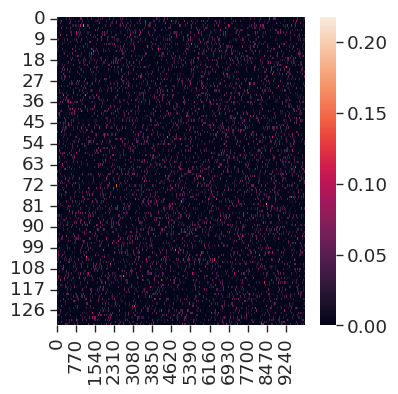

In [16]:
# Plot non-binary version of A0 

sns.heatmap(matrix_np)

In [17]:
check_results(B0s)

Sparsity of CPU is 0.0001
Sparsity of gpu_sparse is 0.0001
Nonzero elements of CPU are different from nonzero elements of gpu_sparse
Sparsity of gpu_dense is 0.0001
Nonzero elements of CPU are different from nonzero elements of gpu_dense


In [18]:
initial_As = {'cpu': model2.A_, 'gpu_sparse': model4.A_, 'gpu_dense': model3.A_}

In [19]:
check_results(initial_As)

Sparsity of CPU is 0.2953135338345865
Sparsity of gpu_sparse is 0.2946766917293233
Nonzero elements of CPU are different from nonzero elements of gpu_sparse
Sparsity of gpu_dense is 0.29307744360902255


Nonzero elements of CPU are different from nonzero elements of gpu_dense


In [20]:
# Ge the initial As for gpu sparse 
A0_gpu_sparse = initial_As['gpu_sparse'] 

# Get the freuqency table of the initial As 
freq_table = pd.Series(A0_gpu_sparse.get().toarray().flatten()).value_counts() 

# Get the first 50 rows of the frequency table 
subset = freq_table.head(50)

# Find the max in the index of subset 
print(max(subset.index)) 

# Find the max in the index of freq_table
print(max(freq_table.index))

0.0392156862745098
1.0


/tmp/ipykernel_36670/3056866196.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(A0_gpu_sparse.get().toarray().flatten())


(0.0, 0.2)

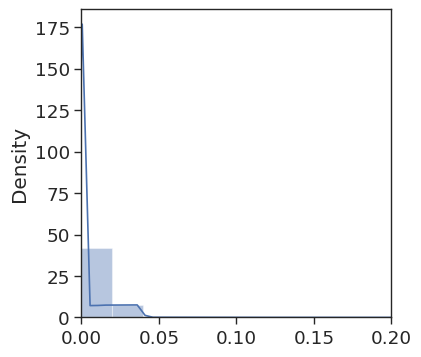

In [21]:
# Make a distribution plot of the values in A0_gpu_sparse
sns.distplot(A0_gpu_sparse.get().toarray().flatten())


filtered = A0_gpu_sparse.copy()
filtered.data[filtered.data < 0.0006] = 0

# Set the x axis between 0 and 0.2
plt.xlim(0, 0.2)

/tmp/ipykernel_36670/259787256.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(A0s['cpu'].toarray().flatten())


(0.0, 0.2)

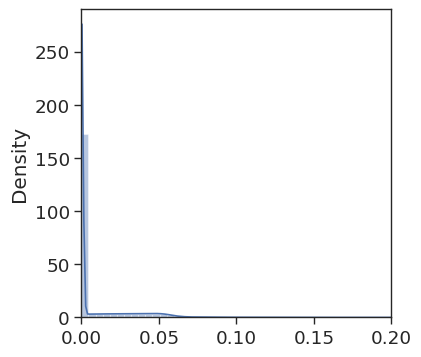

In [69]:
# Make a distribution plot of the values in the cpu version of A0 

sns.distplot(A0s['cpu'].toarray().flatten())
# Set the x axis between 0 and 0.2 
plt.xlim(0, 0.2)


<AxesSubplot: >

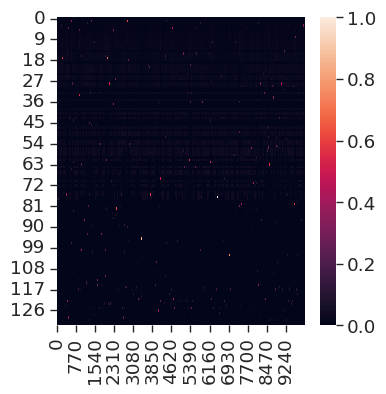

In [23]:
# heatmap of filtered 
sns.heatmap(filtered.get().toarray())

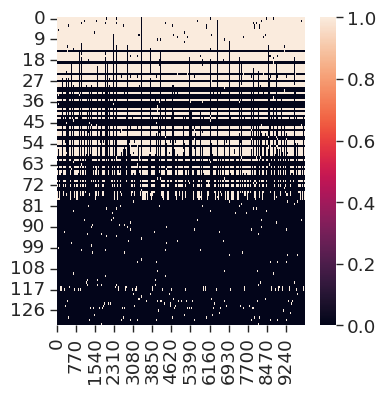

In [24]:
# binary heatmap of filtered 
plot_matrix(filtered.get().toarray())

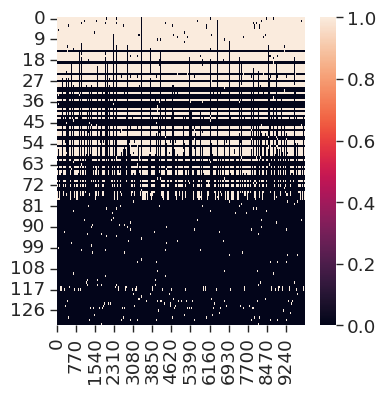

In [25]:
# Process initial_As gpu sparse version for plotting 

M = initial_As['gpu_sparse'] 
matrix_np = M.get().toarray() 

plot_matrix(matrix_np, title='A_')

In [26]:
# Check the sparsity of filtered 

print('Sparsity of filtered is {}'.format(compute_sparsity(filtered.get())))

Sparsity of filtered is 0.2946766917293233


<AxesSubplot: >

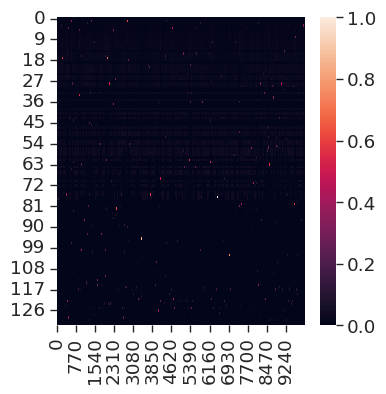

In [27]:
# Print non-binary version of A_ 
M = initial_As['gpu_sparse'] 
matrix_np = M.get().toarray() 
sns.heatmap(matrix_np)

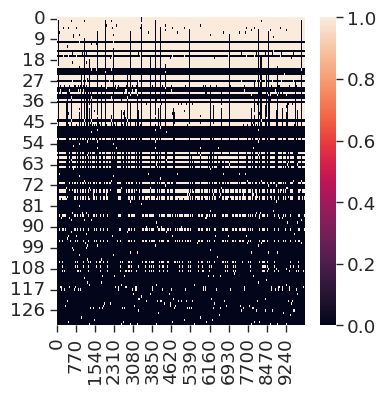

In [28]:
# Make a binary heatmap for cpu A 
M = initial_As['cpu']
matrix_np = M.toarray() 

plot_matrix(matrix_np, title='A_')

<AxesSubplot: >

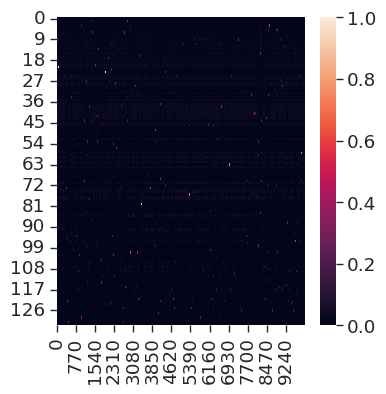

In [29]:
# Make a non-binary heatmap for cpu A 
M = initial_As['cpu']
matrix_np = M.toarray()
sns.heatmap(matrix_np)

In [30]:
def _updateA_cpu(self, B, A_prev):
    """Update step for assigment matrix A.

    Given archetype matrix B and using kernel matrix K, compute assignment matrix A using constrained gradient
    descent via Frank-Wolfe algorithm.

    :param B: (n x k csr_matrix) defining SEACells as weighted combinations of cells
    :param A_prev: (n x k csr_matrix) defining previous weights used for assigning cells to SEACells
    :return: (n x k csr_matrix) defining updated weights used for assigning cells to SEACells
    """
    n, k = B.shape
    A = A_prev

    t = 0  # current iteration (determine multiplicative update)

    # precompute some gradient terms
    t2 = (self.K @ B).T
    t1 = t2 @ B

    # update rows of A for given number of iterations
    while t < self.max_FW_iter:
        # compute gradient (must convert matrix to ndarray)
        G = 2.0 * np.array(t1 @ A - t2)

        # # get argmins - shape 1 x n
        amins = np.argmin(G, axis=0)
        amins = np.array(amins).reshape(-1)

        # # loop free implementation
        e = csr_matrix((np.ones(len(amins)), (amins, np.arange(n))), shape=A.shape)

        A += 2.0 / (t + 2.0) * (e - A)
        t += 1

    return A, t2, t1

In [31]:
def _updateB_cpu(self, A, B_prev):
    """Update step for archetype matrix B.

    Given assignment matrix A and using kernel matrix K, compute archetype matrix B using constrained gradient
    descent via Frank-Wolfe algorithm.

    :param A: (n x k csr_matrix) defining weights used for assigning cells to SEACells
    :param B_prev: (n x k csr_matrix) defining previous SEACells as weighted combinations of cells
    :return: (n x k csr_matrix) defining updated SEACells as weighted combinations of cells
    """
    K = self.K
    k, n = A.shape

    B = B_prev

    # keep track of error
    t = 0

    # precompute some terms
    t1 = A @ A.T
    t2 = K @ A.T

    # update rows of B for a given number of iterations
    while t < self.max_FW_iter:
        # compute gradient (need to convert np.matrix to np.array)
        G = 2.0 * np.array(K @ B @ t1 - t2)

        # get all argmins
        amins = np.argmin(G, axis=0)
        amins = np.array(amins).reshape(-1)

        e = csr_matrix((np.ones(len(amins)), (amins, np.arange(k))), shape=B.shape)

        B += 2.0 / (t + 2.0) * (e - B)

        t += 1

    return B

In [32]:
from cupyx.scipy.sparse.linalg import norm

def _updateA_gpu(self, Bg, Ag):
    """Compute assignment matrix A using constrained gradient descent via Frank-Wolfe algorithm.

    Given archetype matrix B and using kernel matrix K, compute assignment matrix A using constrained gradient
    descent via Frank-Wolfe algorithm.

    :param B: (n x k csr_matrix) defining SEACells as weighted combinations of cells
    :param A_prev: (n x k csr_matrix) defining previous weights used for assigning cells to SEACells
    :return: (n x k csr_matrix) defining updated weights used for assigning cells to SEACells
    """
    n, k = Bg.shape
    t = 0  # current iteration (determine multiplicative update)
    Kg = self.K

    # precompute some gradient terms
    t2g = (Kg @ Bg).T
    t1g = t2g @ Bg

    lambda_l1 = 0.05  
    lambda_l2 = 0.05

    # update rows of A for given number of iterations
    while t < self.max_FW_iter: 
        # L1 regularization term: the weight times the L1 norm of the matrix
        l1_term = lambda_l1 * norm(Ag, ord=1)
        # L2 regularization term: 0.5 times the weight times the L2 norm of the matrix squared
        l2_term = 0.5 * lambda_l2 * norm(Ag, ord = 'fro')**2

        # Add l1 and l2 regularization to the following line
        Gg = 2.0*(t1g @ Ag - t2g)  + l1_term + l2_term
        amins = Gg.argmin(axis = 0)
        
        eg = cp.zeros((k, n))
        eg[amins, cp.arange(n)] = 1.0
        eg = cupyx.scipy.sparse.csr_matrix(eg) 

        Ag += 2.0 / (t + 2.0) * (eg - Ag)
        t += 1
        
    
    return Ag, t2g, t1g

### Stuff to Hide

In [33]:
def _updateB_gpu(self, Ag, Bg):
    """Compute archetype matrix B using constrained gradient descent via Frank-Wolfe algorithm.

    Given assignment matrix A and using kernel matrix K, compute archetype matrix B using constrained gradient
    descent via Frank-Wolfe algorithm.

    :param A: (n x k csr_matrix) defining weights used for assigning cells to SEACells
    :param B_prev: (n x k csr_matrix) defining previous SEACells as weighted combinations of cells
    :return: (n x k csr_matrix) defining updated SEACells as weighted combinations of cells
    """
    # ic("_updateB")
    k, n = Ag.shape

    # keep track of error
    t = 0

    Kg = self.K
    # precompute some terms
    t1g = Ag.dot(Ag.T)
    t2g = Kg.dot(Ag.T)

    # update rows of B for a given number of iterations
    while t < self.max_FW_iter:
        # compute gradient
        Gg = 2 * (Kg.dot(Bg).dot(t1g) -t2g)

        # get all argmins
        amins = Gg.argmin(axis=0)

        eg = cp.zeros((n, k))
        eg[amins, cp.arange(k)] = 1.0
        eg = cupyx.scipy.sparse.csr_matrix(eg)

        f = 2.0 / (t + 2.0)
        Bg = Bg + (f * (eg - Bg))

        t += 1


    del (
        t1g,
        t2g,
        Ag,
        Kg,
        Gg,
        eg,
        amins,
    )
    cp._default_memory_pool.free_all_blocks()

    return Bg

In [34]:
A_cpu = model2.A_
B_cpu = model2.B_

In [35]:
A_gpu = model4.A_
B_gpu = model4.B_

In [36]:
K_gpu = model4.K 
K_cpu = model2.K

In [37]:
ic(A_cpu.shape, B_cpu.shape, A_gpu.shape, B_gpu.shape, K_gpu.shape, K_cpu.shape)

ic| A_cpu.shape: (133, 10000)
    B_cpu.shape: (10000, 133)
    A_gpu.shape: (133, 10000)
    B_gpu.shape: (10000, 133)
    K_gpu.shape: (10000, 10000)
    K_cpu.shape: (10000, 10000)


((133, 10000),
 (10000, 133),
 (133, 10000),
 (10000, 133),
 (10000, 10000),
 (10000, 10000))

In [38]:
# Print out the sparsity measures of the matrices 
ic(A_cpu.nnz / (A_cpu.shape[0] * A_cpu.shape[1]), 
   B_cpu.nnz / (B_cpu.shape[0] * B_cpu.shape[1]),
   A_gpu.nnz / (A_gpu.shape[0] * A_gpu.shape[1]), 
   B_gpu.nnz / (B_gpu.shape[0] * B_gpu.shape[1]), 
   K_cpu.nnz / (K_gpu.shape[0] * K_gpu.shape[1]),
   K_gpu.nnz / (K_cpu.shape[0] * K_cpu.shape[1]))

ic| A_cpu.nnz / (A_cpu.shape[0] * A_cpu.shape[1]): 0.2953135338345865
    B_cpu.nnz / (B_cpu.shape[0] * B_cpu.shape[1]): 0.0001
    A_gpu.nnz / (A_gpu.shape[0] * A_gpu.shape[1]): 0.2946766917293233
    B_gpu.nnz / (B_gpu.shape[0] * B_gpu.shape[1]): 0.0001
    K_cpu.nnz / (K_gpu.shape[0] * K_gpu.shape[1]): 0.01970384
    K_gpu.nnz / (K_cpu.shape[0] * K_cpu.shape[1]): 0.01970384


(0.2953135338345865,
 0.0001,
 0.2946766917293233,
 0.0001,
 0.01970384,
 0.01970384)

In [39]:
# Check the types of the matrices 
ic(type(A_cpu), type(B_cpu), type(A_gpu), type(B_gpu), type(K_cpu), type(K_gpu))

ic| type(A_cpu): <class 'scipy.sparse.csc.csc_matrix'>
    type(B_cpu): <class 'scipy.sparse.csr.csr_matrix'>
    type(A_gpu): <class 'cupyx.

scipy.sparse._csr.csr_matrix'>
    type(B_gpu): <class 'cupyx.scipy.sparse._csr.csr_matrix'>
    type(K_cpu): <class 'scipy.sparse.csr.csr_matrix'>
    type(K_gpu): <class 'cupyx.scipy.sparse._csr.csr_matrix'>


(scipy.sparse.csc.csc_matrix,
 scipy.sparse.csr.csr_matrix,
 cupyx.scipy.sparse._csr.csr_matrix,
 cupyx.scipy.sparse._csr.csr_matrix,
 scipy.sparse.csr.csr_matrix,
 cupyx.scipy.sparse._csr.csr_matrix)

In [40]:
# Check the data types of the matrices 
ic(A_cpu.dtype, B_cpu.dtype, A_gpu.dtype, B_gpu.dtype, K_cpu.dtype, K_gpu.dtype)

ic| A_cpu.dtype: dtype('float64')
    B_cpu.dtype: 

dtype('float64')
    A_gpu.dtype: dtype('float64')
    B_gpu.dtype: dtype('float64')
    K_cpu.dtype: dtype('float64')
    K_gpu.dtype: dtype('float64')


(dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'),
 dtype('float64'))

In [41]:
# Compare K_cpu and K_gpu

diff = K_cpu - K_gpu.get()

# Create a frequency table of the differences 
ic(pd.value_counts(diff.toarray().flatten()))

ic| pd.value_counts(diff.toarray().flatten()):  0.000000e+00    99771847
                                               -5.551115e-17       34444
                                                5.551115e-17       33850
                                                2.220446e-16       32110
                                               -2.220446e-16       31949
                                                1.110223e-16       31642
                                               -1.110223e-16       31314
                                               -4.440892e-16       11506
                                                4.440892e-16       11393
                                               -2.775558e-17        2929
                                                2.775558e-17        2888
                                               -8.881784e-16        1694
                                                8.881784e-16        1632
                                                1.7

 0.000000e+00    99771847
-5.551115e-17       34444
 5.551115e-17       33850
 2.220446e-16       32110
-2.220446e-16       31949
 1.110223e-16       31642
-1.110223e-16       31314
-4.440892e-16       11506
 4.440892e-16       11393
-2.775558e-17        2929
 2.775558e-17        2888
-8.881784e-16        1694
 8.881784e-16        1632
 1.776357e-15         164
-6.661338e-16         124
-1.776357e-15         119
 6.661338e-16         101
-1.332268e-15          93
 1.332268e-15          88
 2.664535e-15          25
-3.330669e-16          20
-2.664535e-15          16
 3.330669e-16          13
-3.552714e-15          11
 1.387779e-17           9
-1.387779e-17           7
 3.552714e-15           6
 1.665335e-16           3
-4.440892e-15           1
 2.220446e-15           1
-1.665335e-16           1
dtype: int64

In [42]:
# Set A_gpu and B_gpu to be the same as A_cpu and B_cpu, but with the same type as A_gpu and B_gpu 
A_gpu = cupyx.scipy.sparse.csr_matrix(A_cpu)
B_gpu = cupyx.scipy.sparse.csr_matrix(B_cpu)

# Set model4.K to be the same as model2.K, but with the same type as model4.K
model4.K = cupyx.scipy.sparse.csr_matrix(model2.K)

In [43]:
# check if the K matrices are the same 

diff = model2.K - model4.K.get()

# Create a frequency table of the differences
ic(pd.value_counts(diff.toarray().flatten()))

ic| pd.value_counts(diff.toarray().flatten()): 0.0    100000000
                                               dtype: int64


0.0    100000000
dtype: int64

In [44]:
# Check if the A matrices are the same 
diff = A_cpu - A_gpu.get()

# Create a frequency table of the differences
ic(pd.value_counts(diff.toarray().flatten()))


ic| pd.value_counts(diff.toarray().flatten()): 0.0    1330000
                                               dtype: int64


0.0    1330000
dtype: int64

In [45]:
# Check if the B matrices are the same 
diff = B_cpu - B_gpu.get()

# Create a frequency table of the differences
ic(pd.value_counts(diff.toarray().flatten()))

ic| pd.value_counts(diff.toarray().flatten()): 0.0    1330000
                                               dtype: int64


0.0    1330000
dtype: int64

In [46]:
t2 = (model2.K @ B_cpu).T
t1 = t2 @ B_cpu 

t2g = (model4.K @ B_gpu).T 
t1g = t2g @ B_gpu

# Check if the t2 matrices are the same
diff = t2 - t2g.get()

# Create a frequency table of the differences
ic(pd.value_counts(diff.toarray().flatten()))

# Check if the t1 matrices are the same
diff = t1 - t1g.get()

# Create a frequency table of the differences
ic(pd.value_counts(diff.toarray().flatten()))


ic| pd.value_counts(diff.toarray().flatten()): 0.0    1330000
                                               dtype: int64
ic| pd.value_counts(diff.toarray().flatten()): 0.0    17689
                                               dtype: int64


0.0    17689
dtype: int64

In [47]:
# Check the data types of the t2, t2g, t1, t1g matrices

ic(t2.dtype, t2g.dtype, t1.dtype, t1g.dtype)

ic| t2.dtype: dtype('float64')
    t2g.dtype: dtype('float64')
    t1.dtype: dtype('float64')
    t1g.dtype: dtype('float64')


(dtype('float64'), dtype('float64'), dtype('float64'), dtype('float64'))

In [48]:
G = t1 @ A_cpu 
Gg = cupyx.scipy.sparse.csr_matrix(t1) @ cupyx.scipy.sparse.csr_matrix(A_cpu)

# Check if the G matrices are the same
diff = G - Gg.get()

# Create a frequency table of the differences
ic(pd.value_counts(diff.toarray().flatten()))

ic| pd.value_counts(diff.toarray().flatten()):  0.000000e+00    1327960
                                                5.551115e-17        240
                                               -5.551115e-17        238
                                               -1.110223e-16        213
                                                1.110223e-16        203
                                               -2.775558e-17        193
                                                2.775558e-17        167
                                               -2.220446e-16        145
                                                2.220446e-16        135
                                                1.387779e-17        117
                                               -1.387779e-17         84
                                                6.938894e-18         53
                                               -6.938894e-18         42
                                                4.440892e-16    

 0.000000e+00    1327960
 5.551115e-17        240
-5.551115e-17        238
-1.110223e-16        213
 1.110223e-16        203
-2.775558e-17        193
 2.775558e-17        167
-2.220446e-16        145
 2.220446e-16        135
 1.387779e-17        117
-1.387779e-17         84
 6.938894e-18         53
-6.938894e-18         42
 4.440892e-16         37
-4.440892e-16         34
 3.469447e-18         33
-3.469447e-18         33
 1.734723e-18         20
 8.673617e-19         19
-1.734723e-18         16
-8.673617e-19         14
 8.881784e-16          4
dtype: int64

In [49]:
amins = Gg.argmin(axis = 0)

n, k = B_gpu.shape
        
eg = cp.zeros((k, n))
eg[amins, cp.arange(n)] = 1.0
eg = cupyx.scipy.sparse.csr_matrix(eg)

In [50]:
amins = np.argmin(G, axis=0)
amins = np.array(amins).reshape(-1)

# # loop free implementation
e = csr_matrix((np.ones(len(amins)), (amins, np.arange(n))), shape=A_cpu.shape)

In [51]:
# Get a frequency table of the elements in eg
ic(pd.value_counts(eg.get().toarray().flatten()))

ic| pd.value_counts(eg.get().toarray().flatten()): 0.0    1320000
                                                   1.0      10000
                                                   dtype: int64


0.0    1320000
1.0      10000
dtype: int64

In [52]:
# Get a frequency table of the elements in e 
ic(pd.value_counts(e.toarray().flatten()))

ic| pd.value_counts(e.toarray().flatten()): 0.0    1320000
                                            1.0      10000
                                            dtype: int64


0.0    1320000
1.0      10000
dtype: int64

### Next Section

In [53]:
# Run updateA on CPU and GPU and compare the results 

# CPU
A_cpu_2, t2, t1 = _updateA_cpu(model2, B_cpu, A_cpu)

# GPU
A_gpu_2, t2g, t1g = _updateA_gpu(model4, B_gpu, A_gpu)

In [54]:
# Compare the sparsity of A_cpu_2 and A_gpu_2 
ic(A_cpu_2.nnz / (A_cpu_2.shape[0] * A_cpu_2.shape[1]), 
   A_gpu_2.nnz / (A_gpu_2.shape[0] * A_gpu_2.shape[1]))

ic| A_cpu_2.nnz / (A_cpu_2.shape[0] * A_cpu_2.shape[1]): 0.2972796992481203
    A_gpu_2.nnz / (A_gpu_2.shape[0] * A_gpu_2.shape[1]): 0.30138796992481204


(0.2972796992481203, 0.30138796992481204)

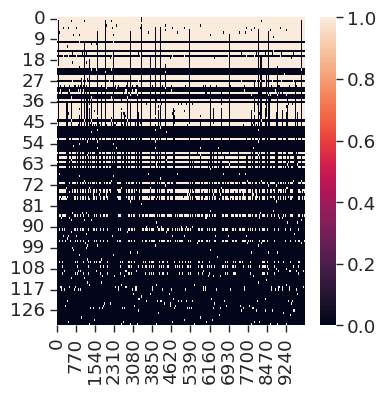

In [55]:
# Heatmap of A_gpu_2

plot_matrix(A_gpu_2.get().toarray(), title='A_gpu_2')

<AxesSubplot: >

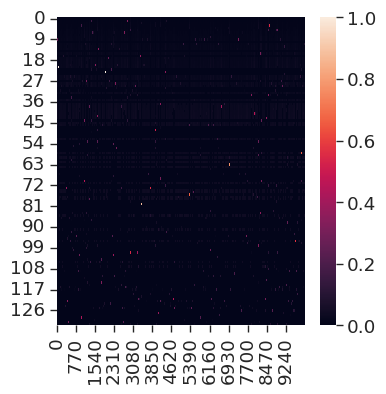

In [56]:
# Plot non-binary version of A_gpu_2 

sns.heatmap(A_gpu_2.get().toarray())

In [57]:
# Compare the values of A_cpu_2 and A_gpu_2 
diff = A_cpu_2 - A_gpu_2.get() 

ic(type(diff))

# Create a frequency table of the differences 
ic(pd.value_counts(diff.toarray().flatten()))

ic| type(diff): <class 'scipy.sparse.csc.csc_matrix'>
ic| pd.value_counts(diff.toarray().flatten()): 0.0    1330000
                                               dtype: int64


0.0    1330000
dtype: int64

In [58]:
# Compare t1 and t1g 
diff = t1 - t1g.get()

# Create a frequency table of the differences
ic(pd.value_counts(diff.toarray().flatten()))

ic| pd.value_counts(diff.toarray().flatten()): 0.0    17689
                                               dtype: int64


0.0    17689
dtype: int64

In [59]:
# Compare t2 and t2g 

diff = t2 - t2g.get()

# Create a frequency table of the differences
ic(pd.value_counts(diff.toarray().flatten()))

ic| pd.value_counts(diff.toarray().flatten()): 0.0    1330000
                                               dtype: int64


0.0    1330000
dtype: int64

In [60]:
# Run updateB on CPU and GPU and compare the results

# CPU
B_cpu_2 = _updateB_cpu(model2, A_cpu, B_cpu)

# GPU
B_gpu_2 = _updateB_gpu(model4, A_gpu, B_gpu)

# Compare the sparsity of B_cpu_2 and B_gpu_2
ic(B_cpu_2.nnz / (B_cpu_2.shape[0] * B_cpu_2.shape[1]), 
   B_gpu_2.nnz / (B_gpu_2.shape[0] * B_gpu_2.shape[1]))

ic| B_cpu_2.nnz / (B_cpu_2.shape[0] * B_cpu_2.shape[1]): 0.001300751879699248
    B_gpu_2.nnz / (B_gpu_2.shape[0] * B_gpu_2.shape[1]): 0.0013045112781954887


(0.001300751879699248, 0.0013045112781954887)

In [61]:
# Compare the values of B_cpu_2 and B_gpu_2
diff = B_cpu_2 - B_gpu_2.get()

ic(type(diff))

ic| type(diff): <class 'scipy.sparse.csr.csr_matrix'>


scipy.sparse.csr.csr_matrix

In [62]:
# Create a frequency table of the differences 
ic(pd.value_counts(diff.toarray().flatten()))

ic| pd.value_counts(diff.toarray().flatten()): 0.0    1330000
                                               dtype: int64


0.0    1330000
dtype: int64

In [63]:
amins = Gg.argmin(axis = 0)
        
eg = cp.zeros((k, n))
eg[amins, cp.arange(n)] = 1.0
eg = cupyx.scipy.sparse.csr_matrix(eg)

In [64]:
ic(type(eg), type(e))

ic| type(eg): <class 'cupyx.scipy.sparse._csr.csr_matrix'>
    type(e): <class 'scipy.sparse.csr.csr_matrix'>

(cupyx.scipy.sparse._csr.csr_matrix, scipy.sparse.csr.csr_matrix)

In [65]:
ic(type(A_gpu), type(A_cpu))

ic| type(A_gpu): <class 'cupyx.scipy.sparse._csr.csr_matrix'>
    type(A_cpu): <class 

'scipy.sparse.csc.csc_matrix'>


(cupyx.scipy.sparse._csr.csr_matrix, scipy.sparse.csc.csc_matrix)

In [66]:
t = 1
Ag = A_gpu + 2.0 / (t + 2.0) * (eg - A_gpu)

In [67]:
A = A_cpu+ 2.0 / (t + 2.0) * (e - A_cpu)

In [68]:
ic(type(Ag), type(A))

# Compare the values of Ag and A 
diff = Ag.get() - A.tocsr()

# Frequency table of the differences
ic(pd.value_counts(diff.toarray().flatten()))

ic| type(Ag): <class 'cupyx.scipy.sparse._csr.csr_matrix'>
    type(A): <class 'scipy.sparse.csc.csc_matrix'>


ic| pd.value_counts(diff.toarray().flatten()): 0.0    1330000
                                               dtype: int64


0.0    1330000
dtype: int64